In [1]:
import pandas as pd
import torch
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForCausalLM
import warnings
import os
from vllm import LLM, SamplingParams

In [2]:
warnings.filterwarnings('ignore')
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'
torch.cuda.empty_cache()

In [3]:
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA: True
GPU: NVIDIA GeForce RTX 4060


In [4]:
df = pd.read_csv('data/youtube_comments_1_normalized.csv')[:16384]
print(f"Total comments: {len(df)}")

Total comments: 16384


In [5]:
model_name1 = "Qwen/Qwen2.5-1.5B-Instruct"

llm = LLM(
    model=model_name1,
    gpu_memory_utilization=0.9,
    max_model_len=1024,
    tensor_parallel_size=1,
    dtype='half',
    disable_log_stats=True,
    enforce_eager=True,
    max_num_seqs=16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name1, trust_remote_code=True)

sampling = SamplingParams(max_tokens=4, temperature=0.0)

INFO 12-06 16:57:15 [utils.py:253] non-default args: {'dtype': 'half', 'seed': None, 'max_model_len': 1024, 'max_num_seqs': 16, 'disable_log_stats': True, 'enforce_eager': True, 'model': 'Qwen/Qwen2.5-1.5B-Instruct'}
WARNING 12-06 16:57:15 [arg_utils.py:1175] `seed=None` is equivalent to `seed=0` in V1 Engine. You will no longer be allowed to pass `None` in v0.13.
INFO 12-06 16:57:16 [model.py:637] Resolved architecture: Qwen2ForCausalLM
WARNING 12-06 16:57:16 [model.py:2089] Casting torch.bfloat16 to torch.float16.
INFO 12-06 16:57:16 [model.py:1750] Using max model len 1024
INFO 12-06 16:57:18 [scheduler.py:228] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 12-06 16:57:18 [vllm.py:601] Enforce eager set, overriding optimization level to -O0
INFO 12-06 16:57:18 [vllm.py:707] Cudagraph is disabled under eager mode
WARNING 12-06 16:57:19 [system_utils.py:136] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. 

(EngineCore_DP0 pid=22028) [2025-12-06 16:57:24] INFO _optional_torch_c_dlpack.py:119: JIT-compiling torch-c-dlpack-ext to cache...
(EngineCore_DP0 pid=22028) /home/gllekk/Documents/AI/.venv/lib/python3.12/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:161: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=22028) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=22028)   warnings.warn(


(EngineCore_DP0 pid=22028) INFO 12-06 16:57:26 [cuda.py:411] Using FLASH_ATTN attention backend out of potential backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION']
(EngineCore_DP0 pid=22028) INFO 12-06 16:57:27 [weight_utils.py:527] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.28it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.28it/s]
(EngineCore_DP0 pid=22028) 


(EngineCore_DP0 pid=22028) INFO 12-06 16:57:27 [default_loader.py:308] Loading weights took 0.86 seconds
(EngineCore_DP0 pid=22028) INFO 12-06 16:57:28 [gpu_model_runner.py:3549] Model loading took 2.8876 GiB memory and 3.040692 seconds
(EngineCore_DP0 pid=22028) INFO 12-06 16:57:29 [gpu_worker.py:359] Available KV cache memory: 3.42 GiB
(EngineCore_DP0 pid=22028) INFO 12-06 16:57:29 [kv_cache_utils.py:1286] GPU KV cache size: 127,968 tokens
(EngineCore_DP0 pid=22028) INFO 12-06 16:57:29 [kv_cache_utils.py:1291] Maximum concurrency for 1,024 tokens per request: 124.97x
(EngineCore_DP0 pid=22028) INFO 12-06 16:57:29 [core.py:254] init engine (profile, create kv cache, warmup model) took 1.65 seconds
(EngineCore_DP0 pid=22028) WARNING 12-06 16:57:31 [vllm.py:608] Inductor compilation was disabled by user settings,Optimizations settings that are only active duringInductor compilation will be ignored.
(EngineCore_DP0 pid=22028) INFO 12-06 16:57:31 [vllm.py:707] Cudagraph is disabled under 

In [ ]:
def create_prompt(comment: str) -> str:
    prompt = f"""You are an expert classifier of political stance in English comments about the Ukraine–Russia war.

Your task:
Classify the stance of THIS comment and answer with EXACTLY one word:
- prorussian
- proukrainian
- neutral

Output rules:
- Output MUST be exactly one of: prorussian, proukrainian, neutral.
- Do NOT add any other words, punctuation, quotes, or explanations.
- Answer with ONLY ONE WORD.

Examples:
Comment: "Ruzzia is pure evil! Ukraine has to win!!!"
Classification: proukrainian

Comment: "Slava Ukraini!"
Classification: proukrainian

Comment: "Russia isn't the bad guy, the West lies about everything"
Classification: prorussian

Comment: "This war is horrible for both Russians and Ukrainians"
Classification: neutral

Comment: "Ukraine is Nazi, Russia is liberating"
Classification: prorussian

Comment: "Putler must be stopped"
Classification: proukrainian

NOW CLASSIFY THIS COMMENT:

Comment: "{comment}"

Classification:
"""
    messages = [{"role": "user", "content": prompt}]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )


In [7]:
def parse_label(text: str) -> str:
    text = text.strip().lower()
    first = text.split()[0] if text else ""

    if first in {"prorussian", "proukrainian", "neutral"}:
        return first

    if first.startswith("pror"):
        return "prorussian"
    if first.startswith("prou"):
        return "proukrainian"

    if "proukrain" in text:
        return "proukrainian"
    if "prorussi" in text:
        return "prorussian"

    return "neutral"

In [8]:
BATCH_SIZE = 8192
comments = df['comment'].tolist()
all_labels = []

for i in range(0, len(comments), BATCH_SIZE):
    batch_comments = comments[i:i+BATCH_SIZE]
    batch_prompts = [create_prompt(c) for c in batch_comments]

    outputs = llm.generate(batch_prompts, sampling)
    batch_labels = [parse_label(o.outputs[0].text) for o in outputs]
    all_labels.extend(batch_labels)

df['stance_label'] = all_labels

Adding requests:   0%|          | 0/8192 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8192 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Adding requests:   0%|          | 0/8192 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/8192 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

In [9]:
df.to_csv('final_dataset_with_stance_small_2.csv', index=False)


RESULTS

Total: 16384 comments

Distribution:
  prorussian: 8,679 (53.0%)
  neutral: 7,000 (42.7%)
  proukrainian: 705 (4.3%)


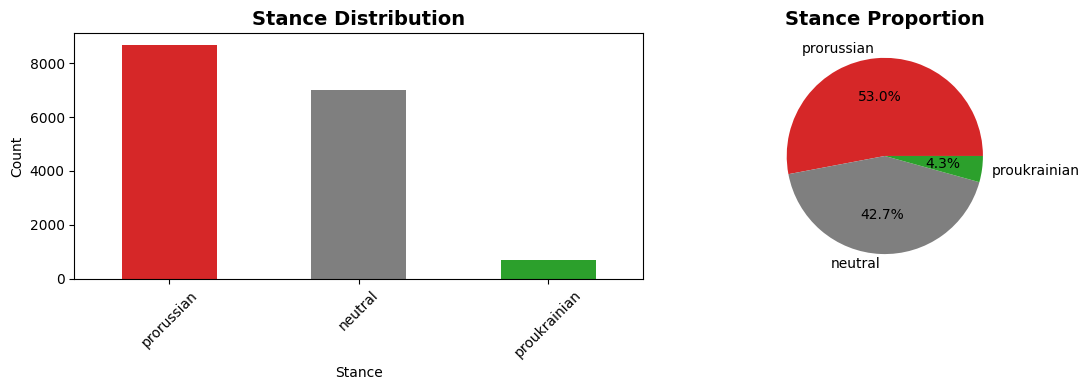


✓ DONE

Sample predictions:
                                             comment  stance_label
0                                          Wow first       neutral
1  Attention! There is all the information about ...    prorussian
2   When did drone became Ukraine secret weopon? huh       neutral
3  Zap straps on a consumer quad copter while Ame...       neutral
4          "Secret weapon." *Puts it on the news.* ☠       neutral
5                                    Free Palestine!       neutral
6                             Stop fundimng Ukraine!  proukrainian
7  A person with groceries = enemy soldier A hous...       neutral
8  Other news have report ur wonderfull tank on f...       neutral
9  Ukraine is losing, Russia is winning. It’s tim...    prorussian


In [ ]:
counts = df['stance_label'].value_counts()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"\nTotal: {len(df)} comments")
print(f"\nDistribution:")
for label, count in counts.items():
    print(f"  {label}: {count:,} ({count/len(df)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

counts.plot(kind='bar', ax=axes[0], color=['#d62728', '#7f7f7f', '#2ca02c'])
axes[0].set_title('Stance Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stance')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#d62728', '#7f7f7f', '#2ca02c'])
axes[1].set_title('Stance Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ DONE")
print("="*60)

print("\nSample predictions:")
print(df[['comment', 'stance_label']].head(10))